# Projet 7 : Implémentez un modèle de scoring
Ce notebook contient la démarche de recherche d'un modèle de scoring crédit et son optimisation.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import random

# pré-processing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# mesure de la performance
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time
import shap

# modèles testés
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm
# sauvegarde des objets
import joblib

In [2]:
random.seed(1)

Import des données nécessaires

In [3]:
# Les données sont construites grâce au script 'kernel_preprocess.py'
data = pd.read_csv('processedData.csv', index_col='SK_ID_CURR')
interestData = pd.read_csv('interestData.csv', index_col='SK_ID_CURR')
descriptions = pd.read_csv(os.path.join(os.getcwd(), "..", 'dashboard/descriptions.csv'))

Nous séparons les variables prédictrices de celle que nous cherchons à prédire.

In [4]:
X = data.loc[:,data.columns !='TARGET']

In [5]:
Y = data['TARGET']

Nous construisons ensuite un set d'entrainement, de test et de validation.

In [6]:
# Nous utilisons une grande proportion de données dans les sets de test et validation car
# Les ressources mémoires disponibles ne permettent pas plus de données d'entrainement
X_train, X_validation, y_train, y_validation = train_test_split(X, Y,
                                                                stratify=Y, 
                                                                test_size=0.5)

X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation,
                                                              stratify=y_validation, 
                                                              test_size=0.5)

Une difficulté majeure pour l'entrainement de notre modèle tient dans l'inégalité des classes à prédire.

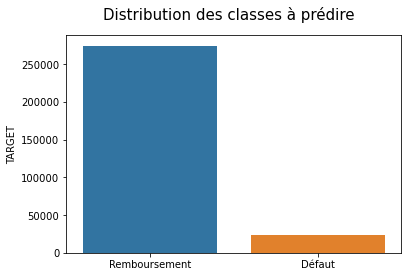

In [12]:
plt.suptitle('Distribution des classes à prédire',fontsize = 15)

sns.barplot(x=[0,1],
            y= Y.value_counts())

plt.xticks([0,1],['Remboursement','Défaut']);

Nous utilisons le score f-beta avec beta = 2 qui est adapté à notre problème (cf note méthodologique)

In [8]:
f_beta_2 = make_scorer(fbeta_score,beta=2)
scoring = {'f_beta':f_beta_2,'recall':'recall'}

Nous allons tester plusieurs combinaisons de modèles et de pré-traitements afin de déterminer la meilleure façon d'aborder ce problème.

In [22]:
def test_model(X,y,model,modelName):
    
    
    
    under = RandomUnderSampler(sampling_strategy=0.5)
    over = SMOTE(n_jobs=-1)
    
    
    simple = [('model', model)]
    underPlusOverSample = [('under',under),('over',over),('model', model)]
    underSample = [('under',under),('model', model)]
    overSample = [('over',over),('model', model)]
    
    preprocessings = [simple,
                     underSample, 
                     overSample,
                     underPlusOverSample]
    
    class_weights = [{0:1,1:1},
                     'balanced']
    
    preprocessType = ['Simple',
                      'undersampling',
                      'oversampling',
                      'undersampling + oversampling',
                      'classWeight + Simple',
                      'classWeight + undersampling',
                      'classWeight + oversampling',
                      'classWeight + undersampling + oversampling']
    f_beta = []
    recall = []
    for weight in class_weights:
        model.class_weights = weight
        for preprocessing in preprocessings:
            pipeline = Pipeline(steps=preprocessing)
            # evaluate pipeline
            cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
            
            metrics = cross_validate(pipeline, X.values, y, scoring=scoring, cv=cv, n_jobs=-1)
            metrics = (pd.DataFrame(metrics).loc[:,['test_f_beta','test_recall']]).mean(axis=0)
            
            f_beta.append(metrics[0])
            recall.append(metrics[1])
    
    return pd.DataFrame({modelName: f_beta},index=preprocessType), pd.DataFrame({modelName: recall},index=preprocessType)

In [24]:
dummy = DummyClassifier()
logit = SGDClassifier(n_jobs=-1,loss='log') 
rdmforest = RandomForestClassifier(n_jobs=-1)
gbm  = lightgbm.LGBMClassifier(n_jobs=-1)

In [25]:
models = [dummy,
          logit,
          rdmforest,
          gbm]
modelNames = ['Dummy Classifier',
              'Logistic Regression',
              'Random Forest',
              'Light GBM']

In [26]:
perfDataFrames = [test_model(X_train,y_train,model, modelName) for model, modelName in zip(models, modelNames)]

In [27]:
f_betas = []
recalls = []
for model in perfDataFrames:
    f_betas.append(model[0])
    recalls.append(model[1])

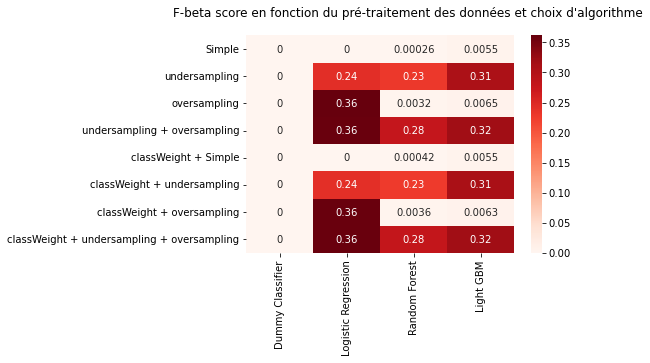

In [28]:
sns.heatmap(pd.concat(f_betas,axis=1),
            cmap='Reds',
            annot=True);
plt.suptitle("F-beta score en fonction du pré-traitement des données et choix d'algorithme");

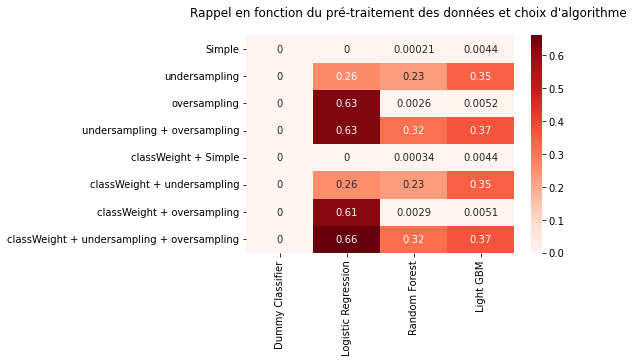

In [29]:
sns.heatmap(pd.concat(recalls,axis=1),
            cmap='Reds',
            annot=True)
plt.suptitle("Rappel en fonction du pré-traitement des données et choix d'algorithme");

La regression logistique semble être le meilleur modèle pour ce prolbème. 
- en ce qui concerne le pré-traitement nous allons utiliser l'undersampling + oversampling avec class weight car le score de rappel est supérieur

### Hyperparameter tuning

In [9]:
under = RandomUnderSampler(sampling_strategy=0.5)
over = SMOTE(n_jobs=-1)

pipeline = Pipeline([('under',under),
                     ('over',over),
                     ('model', SGDClassifier(n_jobs=-1,
                                             class_weight='balanced',
                                             penalty='elasticnet',
                                             loss='log'))])

In [10]:
paramsGrid = {'model__l1_ratio':np.linspace(0,1,20)}
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=4, random_state=1)
Grid = GridSearchCV(pipeline,
                    param_grid=paramsGrid,
                    scoring=f_beta_2,
                    cv=cv, 
                    n_jobs=-1)

In [11]:
Search = Grid.fit(X_train.values,
                 y_train)

In [12]:
Search.best_score_

0.3622061337156878

In [13]:
Search.best_params_

{'model__l1_ratio': 0.894736842105263}

Nous récupérons le meilleur modèle : le troisième élément d'un pipeline

In [14]:
finalModel = Search.best_estimator_[2]

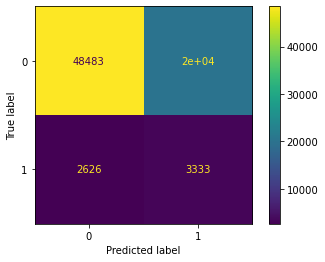

In [15]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,finalModel.predict(X_test.values)))
disp.plot();

In [16]:
fbeta_score(y_test,finalModel.predict(X_test.values),beta=2)

0.35267602057012254

In [17]:
recall_score(y_test,finalModel.predict(X_test.values))

0.559322033898305

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,model.predict(X_test.values)))
disp.plot();

In [ ]:
fbeta_score(y_test,model.predict(X_test.values),beta=2)

In [ ]:
recall_score(y_test,model.predict(X_test.values))

### Performance sur le jeu de validation

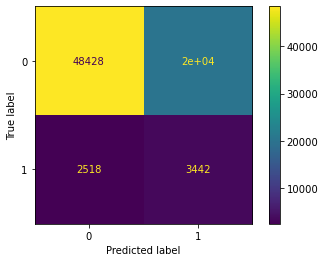

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_validation,finalModel.predict(X_validation.values)))
disp.plot();

In [21]:
fbeta_score(y_validation,finalModel.predict(X_validation.values),beta=2)

0.3629270350063265

In [23]:
recall_score(y_validation,finalModel.predict(X_validation.values))

0.5775167785234899

Les performances sont légèrement inférieures à celles obtenues sur le jeu d'entrainement

## Interprétation globale du modèle

In [24]:
globalImportance = pd.DataFrame({'feature':X.columns,
                                 'coef':finalModel.coef_[0],
                                 'importance':np.abs(finalModel.coef_)[0]}).sort_values(by='importance',ascending=False)

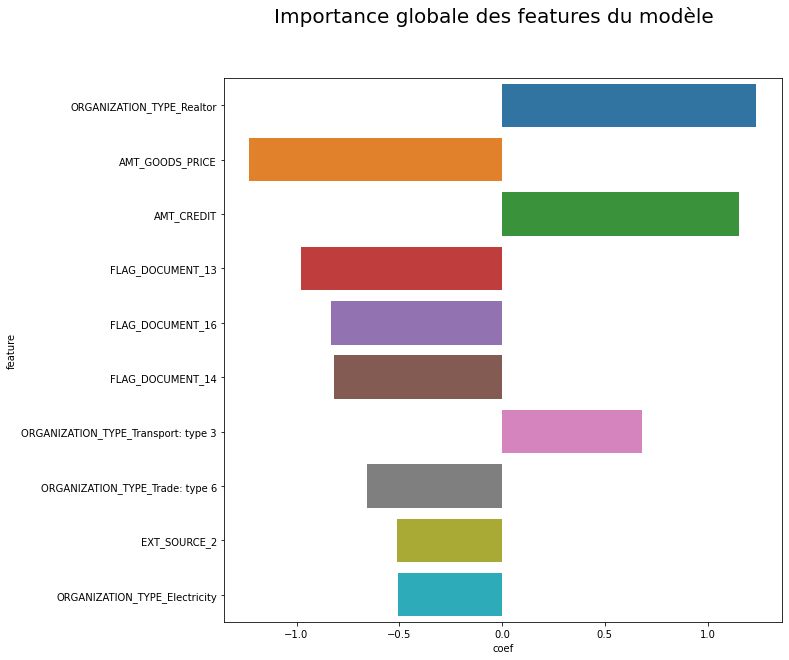

In [26]:
plt.figure(figsize=(10,10))
sns.barplot(x='coef',
            y='feature',
            data=globalImportance.head(10))
plt.suptitle('Importance globale des features du modèle',
             fontsize=20);

- Un remboursement est encodé par un 0 alors qu'un défaut de paiement est encodé par un 1
    - Celà signifie que les **coefficients positifs** témoignent d'une **augmentation du risque** crédit alors que les **négatifs** jouent **en faveur d'une attribution**.

In [27]:
globalImportance.head(10)['feature'].values

array(['ORGANIZATION_TYPE_Realtor', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_14',
       'ORGANIZATION_TYPE_Transport: type 3',
       'ORGANIZATION_TYPE_Trade: type 6', 'EXT_SOURCE_2',
       'ORGANIZATION_TYPE_Electricity'], dtype=object)

Nous sauvegardons notre modèle

In [28]:
joblib.dump(finalModel,os.path.join(os.getcwd(), "..", "API/logitModel.pkl"))

['/home/paul/Documents/openclassrooms/projet 7/projet-dashboard/modélisation/../API/logitModel.pkl']

## Optimisation du seuil d'acceptation
- Nous allons ajouter une dimension métier à notre modèle : 
    

Plutôt que considérer qu'un risque de défaut de paiement supérieur à 50% = un refus, nous allons tenter de définir ce seuil empiriquement sur la base des gains de l'entreprise.

On récupère seulement la probabilité qu'un client ne rembourse pas son prêt

In [29]:
probas = finalModel.predict_proba(X.values)

In [30]:
defaultProba = [proba[1] for proba in probas]

On construit alors un dataset réunissant les probabilités de défaut et le comportement réel des clients

In [31]:
calibrationDataset = pd.DataFrame({'truth':Y.values,
                                   'defaultProba':defaultProba},
                                    index=Y.index)

In [32]:
calibrationDataset

,truth,defaultProba
SK_ID_CURR,,
100002,1.0,0.857319
100003,0.0,0.176649
100004,0.0,0.325204
100007,0.0,0.529957
100008,0.0,0.603543
...,...,...
456251,0.0,0.387860
456252,0.0,0.650499
456253,0.0,0.300544


Nous allons joindre ce dataset avec celui des intérets

In [33]:
interestData

,RATE_INTEREST_PRIMARY,AMT_CREDIT,TARGET
SK_ID_CURR,,,
271877,0.182832,533668.5,0.0
170289,0.196914,225000.0,0.0
250662,0.189136,180000.0,0.0
414811,0.695668,240660.0,0.0
332996,0.191757,182286.0,0.0
...,...,...,...
258580,0.179687,630000.0,0.0
375705,0.193330,675000.0,0.0
446465,0.182818,180000.0,0.0


Malheuresement la colonne 'RATE_INTEREST_PRIMARY' contenant le pourcentage d'intérêt que la banque gagne sur un prêt n'est pas très fournie. 
- Elle compte tout de même + de 4000 points de données.

De plus, la distribution des crédits remboursés et en défaut est fidèle au reste du dataset.

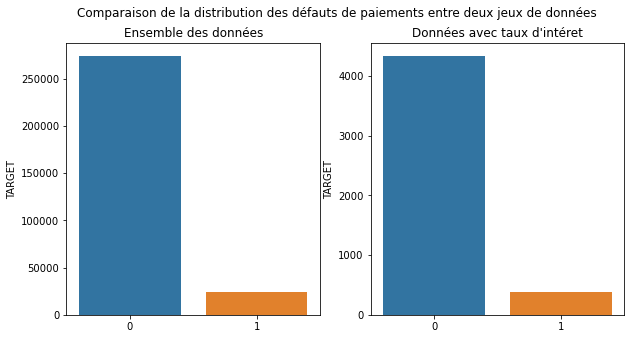

In [34]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.barplot(x=[0,1],
            y= Y.value_counts(),
            ax=ax[0])
ax[0].set_title('Ensemble des données')
sns.barplot(x=[0,1],
            y= interestData['TARGET'].value_counts(),
            ax=ax[1]);
ax[1].set_title("Données avec taux d'intéret")
plt.suptitle('Comparaison de la distribution des défauts de paiements entre deux jeux de données');

Nous multiplions le montant du prêt par le taux d'intérêt pour obtenir le montant récupéré par la banque

In [35]:
interestData['gain'] = interestData['AMT_CREDIT'] * interestData['RATE_INTEREST_PRIMARY']

In [36]:
gainEstimatorData = (interestData.join(calibrationDataset,how='inner')).drop('TARGET',axis=1)

In [37]:
gainEstimatorData

,RATE_INTEREST_PRIMARY,AMT_CREDIT,gain,truth,defaultProba
SK_ID_CURR,,,,,
100069,0.189136,640458.0,121133.887283,0.0,0.705845
100070,0.160716,1227901.5,197343.797688,0.0,0.292779
100285,0.193330,180000.0,34799.387963,0.0,0.543712
100429,0.193330,629325.0,121667.360167,0.0,0.680067
100507,0.196914,450000.0,88611.441687,0.0,0.460702
...,...,...,...,...,...
455997,0.160716,819792.0,131753.944917,0.0,0.808551
456004,0.189122,405000.0,76594.483169,0.0,0.370032
456021,0.189136,405000.0,76600.221013,0.0,0.291308


Grâce à ces données nous pouvons faire varier le seuil à partir duquel on refuse un crédit et observer combien d'argent ce choix nous fait gagner.

In [38]:
def get_balance(data,threshold):
    assumed_returned = data[data['defaultProba'] < threshold]
    returned = assumed_returned[assumed_returned['truth']==0]
    default = assumed_returned[assumed_returned['truth']==1]
    lost = default['AMT_CREDIT'].sum()
    gained = returned['gain'].sum()
    return gained - lost

Nous faisons varier le seuil d'acceptation d'un refus systématique à une acceptation sans condition.

In [39]:
# Nous incrémentons la tolérance du risque de 0.5% à chaque étape
threshs = np.linspace(0,1,200)

In [40]:
balances = [get_balance(gainEstimatorData,thresh) for thresh in threshs]
bestBalance = max(balances)
optimalTreshold = threshs[balances.index(bestBalance)]

In [41]:
plt.style.use('seaborn-darkgrid')

In [42]:
def readable_number(number,tick_number):
    if number < 1000000:
        return np.round(number,2)
    elif number >= 1000000 and number < 1000000000:
        str_number = str(np.round(number / 1000000,2))
        return f'{str_number} Million(s)'
    elif  number >= 1000000000:
        str_number = str(np.round(number / 1000000000,2))
        return f'{str_number} Milliard(s)'

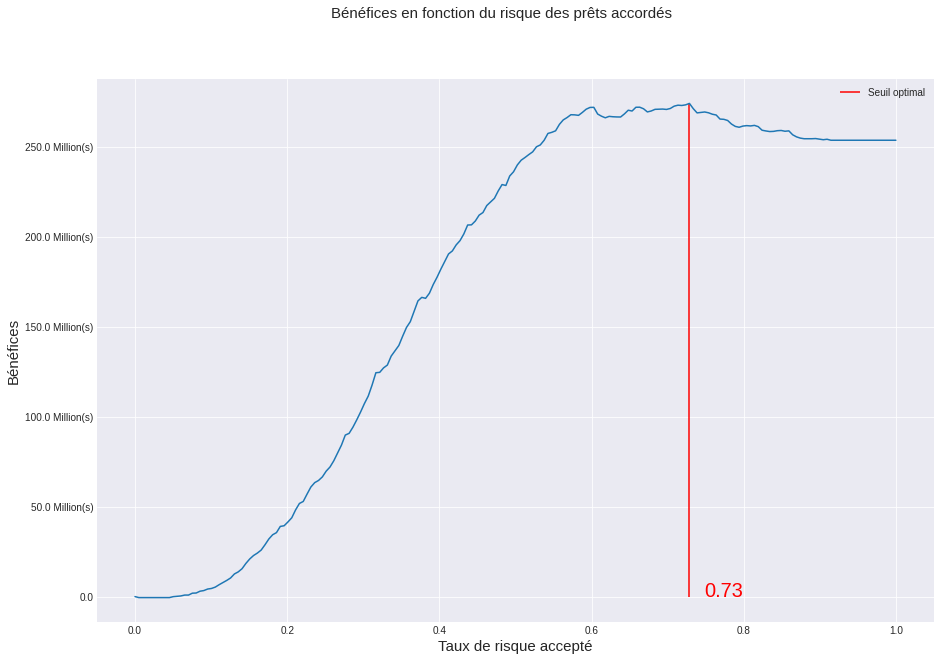

In [43]:
fig, ax = plt.subplots(figsize=(15,10))
ax.vlines(ymax=bestBalance,
           ymin=0, 
           x=optimalTreshold,
           colors='red',
           label='Seuil optimal')
plt.text(x=optimalTreshold+0.02,
         y=0.2,
         s=np.round(optimalTreshold,2),
         fontsize=20,
        color='red')
plt.legend()
plt.plot(threshs,balances)
ax.yaxis.set_major_formatter(plt.FuncFormatter(readable_number))
plt.ylabel("Bénéfices", fontsize=15)
plt.xlabel('Taux de risque accepté', fontsize=15)
plt.suptitle("Bénéfices en fonction du risque des prêts accordés", fontsize=15);

On voit ici que le seuil optimal a été déterminé à 0.73

### Limites :
- Ce seuil a été calculé sur un sous ensemble du jeu de données qui n'est pas représentatif de l'ensemble 

Comparons les clients dont nous disposons d'une information sur leur taux d'intérêt et ceux où il est inconnu.

In [44]:
clientsWithInfo = X[X.index.isin(interestData.index)]
clientsWithoutInfo = X[~X.index.isin(interestData.index)]

In [45]:
from statsmodels.stats.weightstats import ztest as ztest

In [46]:
def get_p_value(column):
    return ztest(clientsWithInfo[column],clientsWithoutInfo[column])[1]
pvalues = [get_p_value(column) for column in X.columns]

In [53]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [54]:
p_adjusted = multipletests(pvalues, method='holm-sidak')

In [67]:
proportionPvalues = pd.Series(p_adjusted[0]).value_counts()
proportionPvalues

False    132
True      59
dtype: int64

In [98]:
print(f"Sur l'ensemble des variables, {(proportionPvalues[1] /proportionPvalues.sum())*100:.2f}% sont \
significativement différentes d'un ensemble de clients à l'autre.")

Sur l'ensemble des variables, 30.89% sont significativement différentes d'un ensemble de clients à l'autre.


### Interprétation des résultats
- Nous allons maintenant expliquer par valeurs shap la décision du modèle pour un cas positif et un cas négatif

In [99]:
individu_1 = 100002  # cas positif
individu_2 = 200001  # cas négatif

In [100]:
calibrationDataset.loc[individu_1,:]

truth           1.000000
defaultProba    0.857319
Name: 100002, dtype: float64

In [101]:
calibrationDataset.loc[individu_2,:]

truth           0.000000
defaultProba    0.406125
Name: 200001, dtype: float64

In [102]:
shap.initjs()

In [104]:
linearExplainer = shap.LinearExplainer(finalModel, X)

In [106]:
joblib.dump(linearExplainer,os.path.join(os.getcwd(), "..", "dashboard/explainer.pkl"))

['/home/paul/Documents/openclassrooms/projet 7/projet-dashboard/modélisation/../dashboard/explainer.pkl']

### Cas positif

In [107]:
shap.force_plot(linearExplainer.expected_value,
                linearExplainer.shap_values(X.loc[individu_1,:]),
                feature_names=X_test.columns)

In [108]:
max_display = 15

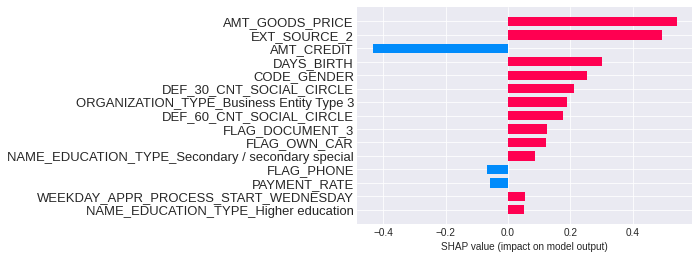

In [109]:
shap.bar_plot(linearExplainer.shap_values(X.loc[individu_1,:]),
              feature_names=X_test.columns,
              max_display=max_display)

### Cas négatif

In [110]:
shap.force_plot(linearExplainer.expected_value,
                linearExplainer.shap_values(X.loc[individu_2,:]),
                feature_names=X_test.columns)

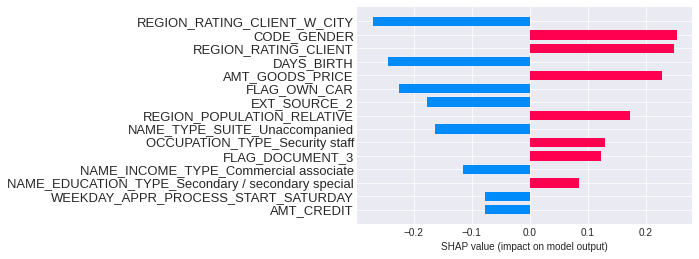

In [111]:
shap.bar_plot(linearExplainer.shap_values(X.loc[individu_2,:]),
              feature_names=X_test.columns,
              max_display=max_display)

#### Explicitation des graphiques
- Ces graphiques nous apportent des informations importantes mais ils manquent d'informations explicites 
    - Que représentent ces noms de features ? 

In [112]:
# Cette fonction nous permet d'obtenir une liste des features considérés les plus importants
def get_features(sk_id_curr):
    shapDF =  pd.DataFrame({'feature':X_test.columns,
                        'shap':linearExplainer.shap_values(X.loc[sk_id_curr,:])})
    orderedShapDF = shapDF.iloc[shapDF.shap.abs().sort_values(ascending=False).index,:]
    return orderedShapDF.head(max_display)['feature'].values

In [113]:
get_features(individu_1)

array(['AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'AMT_CREDIT', 'DAYS_BIRTH',
       'CODE_GENDER', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'ORGANIZATION_TYPE_Business Entity Type 3',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3', 'FLAG_OWN_CAR',
       'NAME_EDUCATION_TYPE_Secondary / secondary special', 'FLAG_PHONE',
       'PAYMENT_RATE', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
       'NAME_EDUCATION_TYPE_Higher education'], dtype=object)

Nous pouvons grâce à cette fonction expliciter le sens des features.

In [114]:
def get_description(featureName):
    info = descriptions[descriptions['Row']==featureName]['Description']
    [print(des) for des in info]

In [130]:
get_description('EXT_SOURCE_2')

Normalized score from external data source


## Conclusion
Nous avons dans ce travail abordé le choix d'un modèle approprié, son optimisation, sa sauvegarde pour un usage ultérieur ainsi que son interprétation.